# An Introduction to PyTorch
by Tobias Jülg

## What is PyTorch?
- Extended version of NumPy for deeplearning
- `np.array` $\rightarrow$ `torch.tensor`
    - GPU accelorated calculations
    - Automatic gradient tracking
- Common optimizer for weight updates
- Define networks with python classes
- Preimplemented common layers and loss functions

## Content
- Tensors: `torch.tensor`
- Datasets & Dataloaders: `torch.utils.data`
- Transformers: `torchvision.transforms`
- Building Networks: `torch.nn`
- Optimizer: `torch.optim`
- Training Loop
- Exercise

## `torch.tensor`
- Very similar to `np.array`: manipulation exactly as in numpy
- Can be executed on the GPU
    - $\rightarrow$ `.to(device)` method
- Compatible to `np.array` if on CPU
- Can track gradients of calculations
    - $\rightarrow$ `requires_grad=True` attribute
- `b = a` always results in reference
    - $\rightarrow$ use `b = a.clone()` to get a separate memory copy!

In [1]:
import torch
tensor = torch.tensor([[1, 2], [3, 4]])
tensor

tensor([[1, 2],
        [3, 4]])

In [2]:
# access dimensions
tensor.shape

torch.Size([2, 2])

### Numpy compatiblity
`.numpy()` and `torch.from_numpy(...)`:

In [4]:
np_array = tensor.numpy()
np_array

array([[1, 2],
       [3, 4]])

In [5]:
torch.from_numpy(np_array)

tensor([[1, 2],
        [3, 4]])

### Data types
- The whole tensor has the same data type: `dtype`
- Set it with `.type(...)`
- Possible types: `torch.int`, `torch.float32`, `torch.float64`
- $\rightarrow$ Standard for DL is float32

In [6]:
# access data type
tensor.dtype

torch.int64

In [7]:
# cast to new data type
tensor.type(torch.float32).dtype

torch.float32

### Tensors on the GPU
- `.device` gives us the current data location
- `.to(...)` moves data between devices
- Tensors need to be on the same device for calculations

In [8]:
# move our tensor to the GPU if available
if torch.cuda.is_available():
    tensor = tensor.to("cuda")
    # torch also supports AMDs ROCm in beta
tensor.device

device(type='cpu')

In [9]:
# error if GPU available
tensor + torch.ones((2, 2))

tensor([[2., 3.],
        [4., 5.]])

### Tensor/Matrix Calculations:
- All common operations default to **element-wise**
- Special methods/operators matrix calculations
- e.g. `@` for matrix multiplication

$$\begin{bmatrix}
1 & 2\\
3 & 4
\end{bmatrix}
\begin{pmatrix}
1\\
1
\end{pmatrix}+
\begin{pmatrix}
1\\
1
\end{pmatrix} = 
\begin{pmatrix}
4\\
8
\end{pmatrix}$$

In [10]:
tensor = torch.tensor([[1, 2], [3, 4]])
tensor @ torch.tensor([1, 1]) + torch.tensor([1, 1])

tensor([4, 8])

In [14]:
# advanced indexing
torch.where(tensor > 1.0)

(tensor([0, 1, 1]), tensor([1, 0, 1]))

### Squeeze and Unsqueeze Dimensions
- Important to match dimensions
- `.squeeze(dim)` can be used to remove a dimension with 1 entry
- `.unsqueeze(dim)` can be used to add a dimension with 1 entry

In [15]:
tensor = torch.tensor([[1, 2, 3, 4]])
tensor.shape

torch.Size([1, 4])

In [16]:
tensor = tensor.unsqueeze(-1)
tensor.shape

torch.Size([1, 4, 1])

In [17]:
tensor.squeeze(0).shape

torch.Size([4, 1])

### Automatic Differentiation
- Tensors can track calculations: `requires_grad` attribute
- Computation graph:
    - Dynamic graph (PyTorch): good for debugging
    - Static graph (Tensorflow): good for production
- `backward()`: traverse computational graph in reverse order, calculates gradients using the chain rule
- Gradients accessible with `grad` attribute


![](graph.png)

Example:

$x=1, w=1, y=2$

$z = x\cdot w = 1$

$loss = (z - y)^2 = 1$

![](graph2.jpg)

In [18]:
x = torch.ones(1)
y = torch.ones(1)*2
w = torch.ones(1, requires_grad=True)

In [19]:
z = w * x
loss = (z-y)**2
loss

tensor([1.], grad_fn=<PowBackward0>)

$$\frac{\partial loss}{\partial w} = \frac{\partial loss}{\partial z}\cdot\frac{\partial z}{\partial w} = 2(z-y) \cdot x = -2$$

In [20]:
# .grad needs to be None before calling .backward()
loss.backward()
w.grad

tensor([-2.])

## Toy Problem
Learn the function $f(x) = x^2$

## `torch.utils.data`
Module for data representation, loading and splitting

In [21]:
from torch.utils.data import Dataset, DataLoader, random_split

### Dataset
- Represents data in form of a python class
- Map-Style
    - Index maps to sample
    - Inherit from `Dataset`
    - Implement `__getitem__` and `__len__` methods
- Iterator-Syle: No fix index
    - No index mapping given e.g. data is randomly generated
    - Inherit from `IterableDataset`
    - Implement `__iter__` method

Learn $x^2$ function for $x\in [-50, 50]$. 
Dataset should contain 10000 sample:

Map Index $\{0, ..., 9999\} \rightarrow [-50, 50]$

$\rightarrow$ **Map-Style dataset**

$$f(i) = (\frac{i}{10000}\cdot 100 - 50)^2$$

Normalize input to $[-1, 1]$

$$norm(i) = \frac{i}{10000}\cdot 2 - 1$$

In [42]:
class MyDataset(Dataset):
    def __getitem__(self, i):
        if i < 0 or i >= len(self):
            raise IndexError
        # normilize input to [0, 1]
        # always return vectors, otherwise nasty broadcast errors might follow
        return torch.tensor([i/10_000*2-1], dtype=torch.float32), torch.tensor([(i/10_000*100-50)**2], dtype=torch.float32)
    def __len__(self):
        return int(10_000.0)

In [ ]:
class MyDataset(Dataset):
    def __getitem__(self, i):
        if i < 0 or i >= len(self):
            raise IndexError
        # normilize input to [0, 1]
        return torch.tensor([i/10_000*100-50], dtype=torch.float32), torch.tensor([(i/10_000*100-50)**2], dtype=torch.float32)
        #return torch.tensor([i/10_000*2-1], dtype=torch.float32), torch.tensor([(i/10_000*100-50)**2], dtype=torch.float32)
    def __len__(self):
        return 10_000

### Splitting
`random_split` takes
- dataset to split
- number of elements in each split
- (optionally) generator to fix random seed

and returns sub-datasets

Example 0.6/0.2/0.2 split:

In [41]:
dataset = MyDataset()
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_data, val_data, test_data = random_split(dataset,
                                               [train_size, val_size, test_size],
                                               generator=torch.Generator().manual_seed(42))

### Dataloader
- Fetches data from dataset
- Can use several fetch workers
- Prepares batches: Iterator of batches
- Optionally reshuffels batch data in each epoch

In [40]:
train = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=0, drop_last=False)
val = DataLoader(val_data, batch_size=64, shuffle=True)
test = DataLoader(test_data, batch_size=64, shuffle=True)

## `torch.nn`: Building Models
- Define networks as a python class
- Recursive network construtction with `nn.module`
- $\rightarrow$ Every network unit is module and can consist of modules itself
- Defines layers, calculation flow through the layers and parameters
- Can be called like a function

In [38]:
import torch.nn.functional as F
from torch.nn import Module, Linear, MSELoss, ReLU, L1Loss
class MyModel(Module):
    def __init__(self):
        super().__init__()
        self.layer1 = Linear(1, 100, bias=True)
        self.act1 = ReLU()
        self.layer2 = Linear(100, 100)
        self.act2 = ReLU()
        self.layer3 = Linear(100, 1)
        
    def forward(self, x):
        return self.layer3(self.act2(self.layer2(self.act1(self.layer1(x)))))

In [39]:
# already initializes weights
model = MyModel()
# acts like a function, input always needs to be batch matrix (single sample: vector)
model(torch.tensor([[10.0], [2.0]]))

tensor([[1.2906],
        [0.2494]], grad_fn=<AddmmBackward0>)

- `parameters()`: Iterates over all learnable weights
- `state_dict()`: Python dictionary which contains the current weight values

In [32]:
# Model's state: weight values
model.state_dict()["layer1.weight"]

tensor([[ 0.9592],
        [ 0.0726],
        [-0.9228],
        [ 0.6859],
        [-0.7280],
        [ 0.7114],
        [-0.6910],
        [-0.5108],
        [-0.9658],
        [ 0.2034],
        [ 0.1898],
        [-0.5138],
        [ 0.2864],
        [-0.8050],
        [-0.5771],
        [-0.9390],
        [ 0.1982],
        [ 0.3592],
        [ 0.7640],
        [ 0.3410],
        [ 0.1092],
        [-0.1244],
        [-0.6911],
        [ 0.0131],
        [-0.6193],
        [ 0.4877],
        [ 0.5649],
        [-0.2504],
        [ 0.6222],
        [ 0.0133],
        [ 0.4826],
        [-0.3736],
        [ 0.2075],
        [ 0.6168],
        [ 0.5092],
        [-0.4441],
        [-0.6959],
        [-0.7803],
        [-0.3449],
        [-0.1461],
        [-0.8836],
        [-0.2711],
        [ 0.3792],
        [ 0.2807],
        [-0.6859],
        [-0.8743],
        [ 0.6515],
        [-0.6292],
        [ 0.2332],
        [ 0.0559],
        [ 0.7979],
        [-0.8890],
        [-0.

### Exkurs Weight Initialization


### Loss Functions
- Defines our optimization problem
- Loss function depends on the problem:
    - Regression:
        - Mean squared error: `MSELoss`
        - Mean absolut error: `L1Loss`
        - Combination: `SmoothL1Loss` (less sensitive to outliers)
    - Classification:
        - Binary cross entropy: `BCELoss`
        - Cross entropy: `CrossEntropyLoss` (for n classes)

In [43]:
# we want to learn a function -> regression, usually MSE is a good pick
loss_fn = MSELoss()

## `torch.optim`: Optimizer
- Optimizer: Strategy to update the weights given the gradients
- Takes parameters to optimize
- Additional optimizer specific parateters
- `.step()` function updates weights
- `.zero_grad()` empties gradients -> needed before every backward pass

- SGD:
    - Stochastic Gradient Desent (GD with mini-batches)
    - first order momentum possible
    - weight decay possible
- Adam:
    - Adaptive Moment Estimation
    - First and second order momentum
    - weight decay possible

In [44]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)

## Training Loop
- Epoch: Iterate over all batches
- For each batch:
    - Pass the batch through the model
    - Calculate the loss
    - Backpropagate and calculate gradients
    - Update weights using the optimizer
    - Log Metrics
- Forward validation dataset and log metrics


In [45]:
for epoch in range(150):
    losses = []
    model.train()
    for batch in train:
        X, y = batch
        y_hat = model(X)
        loss = loss_fn(y_hat, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss)
        
    # evaluation
    losses_val2 = []
    model.eval()
    with torch.no_grad():
        for batch in train:
            X, y = batch
            y_hat = model(X)
            losses_val2.append(loss_fn(y_hat, y))
    
    # evaluation
    losses_val = []
    model.eval()
    with torch.no_grad():
        for batch in val:
            X, y = batch
            y_hat = model(X)
            losses_val.append(loss_fn(y_hat, y))
    l, l_val, l_ = torch.stack(losses).mean().item(), torch.stack(losses_val).mean().item(), torch.stack(losses_val2).mean().item()
    if epoch % 10 == 0:
        print(f"Loss: {l:.10f}, val loss: {l_val:.10f}, train loss: {l_:.10f}")
            

Loss: 1249254.5000000000, val loss: 1193008.0000000000, train loss: 1210606.5000000000
Loss: 101630.0000000000, val loss: 82924.8203125000, train loss: 84228.3203125000
Loss: 6741.1694335938, val loss: 6251.2939453125, train loss: 6212.5278320312
Loss: 1552.9964599609, val loss: 1409.7972412109, train loss: 1447.4603271484
Loss: 404.7177429199, val loss: 357.6051330566, train loss: 376.3672180176
Loss: 126.3145370483, val loss: 110.0412445068, train loss: 119.5708084106
Loss: 48.8971405029, val loss: 42.1058464050, train loss: 46.0612678528
Loss: 19.7660541534, val loss: 16.2278652191, train loss: 18.1943893433


KeyboardInterrupt: 

In [ ]:
X, y = iter(train).next()
X.shape, y.shape, model(X).shape

In [ ]:
for epoch in range(5):
    losses = []
    model.train()
    for batch in train:
        X, y = batch
        y_hat = model(X)
        # shapes must match!
        # y_hat.shape: [64, 1], y.shape: [64]
        y = y.unsqueeze(-1)
        loss = loss_fn(y_hat, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss)
    
    # evaluation
    losses_val = []
    model.eval()
    with torch.no_grad():
        for batch in train:
            X, y = batch
            y_hat = model(X)
            losses_val.append(loss_fn(y_hat, y.unsqueeze(-1)))
    l, l_val = torch.stack(losses).mean().item(), torch.stack(losses_val).mean().item()
    print(f"Loss: {l:.4f}, val loss: {l_val:.4f}")

# PyTorch Lightning
- High level framework based on PyTorch (what Keras is to TF)
- Phylosophy:
    - No room for errors in code that you dont write
    - Concentrate on the important part of DL projects
    - Still able to access deep components if you want to
- Implements base functionality used in most projects
    - Training loop
    - Logging
    - Takes care of pushing data to GPU

In [46]:
import pytorch_lightning as pl

## Lightning Module
- PyTorch module which also defines how training/validation/test steps are performed e.g. `training_step`
- Defines optimizer
- Defines dataloader
- Easy logging
- Possible to hook into other steps in the training pipeline e.g. `validation_epoch_end`

In [47]:
class PLModule(pl.LightningModule):
    def __init__(self, model, data, hparms):
        super().__init__()
        self.model = model
        self.crit = MSELoss()
        self.hparams.update(hparams)
        self.data = data
        
    def training_step(self, batch, batch_idx):
        x, y = batch[0], batch[1]
        y_hat = self.model(x)
        loss = self.crit(y_hat, y)
        self.log("loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        # no need for torch.no_grad() here as lighting handles this
        x, y = batch[0], batch[1]
        y_hat = self.model(x)
        loss = self.crit(y_hat, y)
        self.log("val_loss", loss)
        
    def train_dataloader(self):
        return DataLoader(self.data[0], batch_size=64)

    def val_dataloader(self):
        return DataLoader(self.data[1], batch_size=64)

    def test_dataloader(self):
        return DataLoader(self.data[2], batch_size=64)

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(),
                                self.hparams["learning_rate"],
                                weight_decay=self.hparams["weight_decay"])

hparams = {"learning_rate": 1e-3, "weight_decay": 1e-6, "epochs": 1000}
model = MyModel()
pl_module = PLModule(model, (train_data, val_data, test_data), hparams)

## Lightning Trainer
- Object that defines the training
- `.fit(pl_module)` runs the training
- Callbacks for
    - early stopping
    - checkpoints
    - logging (default: Tensorboard)
    - ...

In [48]:
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint



early_stop_callback = EarlyStopping(
    monitor='val_loss',
     =10,
    strict=True,
    verbose=True,
    mode='min'
)  
model_checkpoint = ModelCheckpoint(
    "ckpts",
    monitor='val_loss',
    save_last=True,
    save_top_k=1,
)
callbacks = [early_stop_callback, model_checkpoint]


trainer = pl.Trainer(
    callbacks=callbacks,
    max_epochs=hparams["epochs"],
    deterministic=True,
    #gpus=[0],
    #profiler="simple",
)
trainer.fit(pl_module)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name  | Type    | Params
----------------------------------
0 | model | MyModel | 10.4 K
1 | crit  | MSELoss | 0     
----------------------------------
10.4 K    Trainable params
0         Non-trainable params
10.4 K    Total params
0.042     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/tobi/cloud/Uni/sem-3/idp/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/tobi/cloud/Uni/sem-3/idp/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 1201541.625


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 191042.688 >= min_delta = 0.0. New best score: 1010498.938


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 323908.062 >= min_delta = 0.0. New best score: 686590.875


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 212505.344 >= min_delta = 0.0. New best score: 474085.531


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 57293.125 >= min_delta = 0.0. New best score: 416792.406


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 38066.844 >= min_delta = 0.0. New best score: 378725.562


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 41106.969 >= min_delta = 0.0. New best score: 337618.594


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 48782.750 >= min_delta = 0.0. New best score: 288835.844


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 51358.156 >= min_delta = 0.0. New best score: 237477.688


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 50097.703 >= min_delta = 0.0. New best score: 187379.984


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 46222.656 >= min_delta = 0.0. New best score: 141157.328


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 38537.312 >= min_delta = 0.0. New best score: 102620.016


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 29803.023 >= min_delta = 0.0. New best score: 72816.992


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 21646.746 >= min_delta = 0.0. New best score: 51170.246


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 14749.637 >= min_delta = 0.0. New best score: 36420.609


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 9488.611 >= min_delta = 0.0. New best score: 26931.998


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 5945.668 >= min_delta = 0.0. New best score: 20986.330


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 3826.965 >= min_delta = 0.0. New best score: 17159.365


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 2685.286 >= min_delta = 0.0. New best score: 14474.079


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 2073.055 >= min_delta = 0.0. New best score: 12401.024


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 1711.419 >= min_delta = 0.0. New best score: 10689.605


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 1459.699 >= min_delta = 0.0. New best score: 9229.906


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 1254.346 >= min_delta = 0.0. New best score: 7975.561


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 1080.885 >= min_delta = 0.0. New best score: 6894.675


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 928.627 >= min_delta = 0.0. New best score: 5966.048


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 796.655 >= min_delta = 0.0. New best score: 5169.393


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 684.326 >= min_delta = 0.0. New best score: 4485.066


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 586.546 >= min_delta = 0.0. New best score: 3898.520


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 503.922 >= min_delta = 0.0. New best score: 3394.599


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 433.166 >= min_delta = 0.0. New best score: 2961.433


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 371.414 >= min_delta = 0.0. New best score: 2590.019


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 320.179 >= min_delta = 0.0. New best score: 2269.841


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 276.378 >= min_delta = 0.0. New best score: 1993.463


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 239.399 >= min_delta = 0.0. New best score: 1754.064


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 208.131 >= min_delta = 0.0. New best score: 1545.933


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 182.356 >= min_delta = 0.0. New best score: 1363.576


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 160.020 >= min_delta = 0.0. New best score: 1203.557


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 140.949 >= min_delta = 0.0. New best score: 1062.607


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 124.231 >= min_delta = 0.0. New best score: 938.376


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 109.744 >= min_delta = 0.0. New best score: 828.632


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 96.887 >= min_delta = 0.0. New best score: 731.745


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 85.562 >= min_delta = 0.0. New best score: 646.183


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 75.309 >= min_delta = 0.0. New best score: 570.874


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 66.150 >= min_delta = 0.0. New best score: 504.724


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 57.980 >= min_delta = 0.0. New best score: 446.744


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 51.067 >= min_delta = 0.0. New best score: 395.676


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 44.898 >= min_delta = 0.0. New best score: 350.778


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 39.303 >= min_delta = 0.0. New best score: 311.475


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 34.344 >= min_delta = 0.0. New best score: 277.132


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 30.030 >= min_delta = 0.0. New best score: 247.101


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 26.458 >= min_delta = 0.0. New best score: 220.643


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 23.230 >= min_delta = 0.0. New best score: 197.413


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 20.387 >= min_delta = 0.0. New best score: 177.026


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 17.978 >= min_delta = 0.0. New best score: 159.048


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 15.916 >= min_delta = 0.0. New best score: 143.131


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 14.115 >= min_delta = 0.0. New best score: 129.016


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 12.531 >= min_delta = 0.0. New best score: 116.485


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 11.153 >= min_delta = 0.0. New best score: 105.332


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 9.988 >= min_delta = 0.0. New best score: 95.344


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 8.833 >= min_delta = 0.0. New best score: 86.511


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 7.961 >= min_delta = 0.0. New best score: 78.549


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 7.138 >= min_delta = 0.0. New best score: 71.411


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 6.446 >= min_delta = 0.0. New best score: 64.965


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 5.906 >= min_delta = 0.0. New best score: 59.059


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 5.356 >= min_delta = 0.0. New best score: 53.703


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 4.880 >= min_delta = 0.0. New best score: 48.823


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 4.452 >= min_delta = 0.0. New best score: 44.371


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 4.017 >= min_delta = 0.0. New best score: 40.354


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 3.642 >= min_delta = 0.0. New best score: 36.713


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 3.318 >= min_delta = 0.0. New best score: 33.394


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 2.923 >= min_delta = 0.0. New best score: 30.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 2.645 >= min_delta = 0.0. New best score: 27.827


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 2.324 >= min_delta = 0.0. New best score: 25.502


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 2.098 >= min_delta = 0.0. New best score: 23.405


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 1.865 >= min_delta = 0.0. New best score: 21.539


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 1.683 >= min_delta = 0.0. New best score: 19.856


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 1.537 >= min_delta = 0.0. New best score: 18.319


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 1.360 >= min_delta = 0.0. New best score: 16.959


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 1.248 >= min_delta = 0.0. New best score: 15.711


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 1.144 >= min_delta = 0.0. New best score: 14.567


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 1.071 >= min_delta = 0.0. New best score: 13.496


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 1.024 >= min_delta = 0.0. New best score: 12.472


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.921 >= min_delta = 0.0. New best score: 11.551


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.819 >= min_delta = 0.0. New best score: 10.732


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.763 >= min_delta = 0.0. New best score: 9.969


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.650 >= min_delta = 0.0. New best score: 9.319


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.617 >= min_delta = 0.0. New best score: 8.702


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.566 >= min_delta = 0.0. New best score: 8.136


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.545 >= min_delta = 0.0. New best score: 7.591


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.569 >= min_delta = 0.0. New best score: 7.023


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.535 >= min_delta = 0.0. New best score: 6.487


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.469 >= min_delta = 0.0. New best score: 6.018


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.410 >= min_delta = 0.0. New best score: 5.608


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.358 >= min_delta = 0.0. New best score: 5.250


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.319 >= min_delta = 0.0. New best score: 4.931


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.303 >= min_delta = 0.0. New best score: 4.628


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.283 >= min_delta = 0.0. New best score: 4.344


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.265 >= min_delta = 0.0. New best score: 4.079


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.244 >= min_delta = 0.0. New best score: 3.836


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.204 >= min_delta = 0.0. New best score: 3.632


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.156 >= min_delta = 0.0. New best score: 3.476


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.146 >= min_delta = 0.0. New best score: 3.330


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.224 >= min_delta = 0.0. New best score: 3.106


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.305 >= min_delta = 0.0. New best score: 2.800


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.355 >= min_delta = 0.0. New best score: 2.446


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.309 >= min_delta = 0.0. New best score: 2.137


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.211 >= min_delta = 0.0. New best score: 1.926


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.116 >= min_delta = 0.0. New best score: 1.810


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.101 >= min_delta = 0.0. New best score: 1.709


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.094 >= min_delta = 0.0. New best score: 1.614


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.127 >= min_delta = 0.0. New best score: 1.488


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.149 >= min_delta = 0.0. New best score: 1.338


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.135 >= min_delta = 0.0. New best score: 1.204


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.086 >= min_delta = 0.0. New best score: 1.118


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.055 >= min_delta = 0.0. New best score: 1.063


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.043 >= min_delta = 0.0. New best score: 1.019


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.037 >= min_delta = 0.0. New best score: 0.982


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 0.948


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.931


Validating: 0it [00:00, ?it/s]

/home/tobi/cloud/Uni/sem-3/idp/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


### Tensorboard
- Website to visualize all sorts of metrics
- Live training progress
- Can also be opened in Jupyter

In [49]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs

## Results

In [50]:
# forward whole dataset
with torch.no_grad():
    y_hat = [model(i[0]).item() for i in dataset]
y = [i[1] for i in dataset]
x = [i[0]*50 for i in dataset]

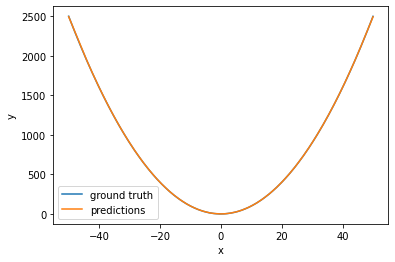

In [52]:
import matplotlib.pyplot as plt
plt.plot(x, y, label="ground truth")
plt.plot(x, y_hat, label="predictions")
plt.ylabel('y')
plt.xlabel('x')
plt.legend()
plt.show()

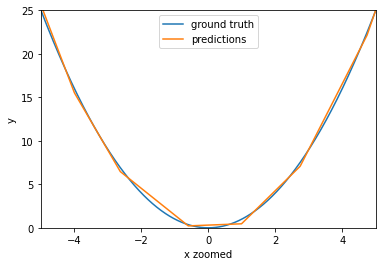

In [53]:
plt.plot(x, y, label="ground truth")
plt.plot(x, y_hat, label="predictions")
plt.xlim([-5, 5])
plt.ylim([0, 25])
plt.ylabel('y')
plt.xlabel('x zoomed')
plt.legend()
plt.show()

In [ ]:
((torch.tensor(y)-torch.tensor(y_hat))**2).mean()

## Tips
- Start small
    - Small model
    - Small dataset $\rightarrow$ overfit a single batch to check that the pipeline is working
- Always check monitor the training progress e.g. Tensorboard
- Visualize the results as low loss does not always imply good results (e.g. loss weakly choosen for the problem)
- Don't be too naive when approaching a problem
- Don't force to use DL on every problem

![](meme.jpg)